$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\cset}[1]{\mathcal{#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$

# CS236781: Deep Learning
# Tutorial 8: Transfer Learning and Domain Adaptation

## Introduction

In this tutorial, we will cover:

- Transfer learning contexts
- Leveraging pre-trained models for supervised domain adaptation
- Unsupervised domain adaptation using adversarial training

In [1]:
# Setup
%matplotlib inline
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['font.size'] = 20
data_dir = os.path.expanduser('~/.pytorch-datasets')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Transfer learning

### The supervised learning context

We have a labeled dataset of $N$ labelled samples: $\left\{ (\vec{x}^i,y^i) \right\}_{i=1}^N$, where
- $\vec{x}^i = \left(x^i_1, \dots, x^i_D\right) \in \mathcal{X}$  is a **sample** or **feature vector**.
- $y^i \in \mathcal{Y}$ is the **label**.
- For classification with $C$ classes, $\mathcal{Y} = \{0,\dots,C-1\}$, so each $y^i$ is a **class label**.
- Usually we assume each labeled sample $(\vec{x}^i,y^i)$
  is drawn from a joint distribution
  $$P(\rvec{X}, \rvar{Y})=P(\rvec{X})\cdot P(\rvar{Y}|\rvec{X})$$
    - We assume some marginal sample distribution $P(\rvar{X})$ exists.
    - We want to learn $P(\rvar{Y}|\rvec{X})$ from the data.

So far, we considered mostly the traditional **supervised learning** setting:

We assumed the **train** and **test** (which is supposed to represent future unseen data)
sets are both from the same **distribution** $P(\rvec{X}, \rvar{Y})=P(\rvec{X})\cdot P(\rvar{Y}|\rvec{X})$ and both labeled.

We were able to assume this since we wanted to solve one task with one dataset, and we could
therefore split our dataset into such sets.

What happens when this is not the case?

In the real world, we often don't have the perfect training set for our problem.

What should we do when the supervised learning assumption is invalid?

<center><img src="img/transfer_learning_digits.png" width="700"/></center>

### Domains, targets and tasks

Lets start with some definitions to explain the problem.

- Imagine we have a **feature space**, $\mathcal{X}$
    - For example, $\mathcal{X}$ is the space of color images of size 32x32, each pixel in the range 0-255

In [3]:
import math
# size of this "limited" feature space
print(f'10^{math.log10(256**(32**2*3)):.0f}')

10^7398


- As usual, we have a training set $X=\{\vec{x}^{(i)}\}_{i=1}^{N},\ \vec{x}^{(i)}\in\cset{X}$.
    - For example, CIFAR-10
    
<center><img src="img/cifar10.png" width="600"/></center>

- There exists some **probability distribution** $P(X)$ (aka $P_{X}(\vec{x})$) over our data.
    - Note that we don't care about the distribution over $\cset{X}$.
    - For example, if $X$ is CIFAR-10, the probability of an all-black image should be very low
    

- Our **label space**, $\cset{Y}$ includes the possible labels for sample in our problem.
    - For example $\cset{Y}=\{0,1\}$ in binary classification.
- We may have also $Y = \{y^{(i)}\}_{i=1}^{N},\ y^{(i)}\in\cset{Y}$, the set of labels for our dataset.

- We want to learn the target function $\hat{y}=f(\vec{x})$ which predicts a label given an image.
    - From the probabilistic perspective, learn $P(\hat{y}|\vec{x})$.

Finally,
- A learning **domain** $\cset{D}$, is defined as $\cset{D}=\left\{\mathcal{X},P(X)\right\}$.
- A learning **task** $\cset{T}$ is defined as $\cset{T}=\{\cset{Y},P(Y|X)\}$.

### Transfer learning settings

**Definition** (Pan & Yang, 2010):

Given
- A **source** domain $\cset{D}_S=\left\{\mathcal{X}_S,P(X_S)\right\}$ and source learning task
  $\cset{T}_S = \{\cset{Y}_S,P(Y_S|X_S)\}$
  
- A **target** domain $\cset{D}_T=\left\{\mathcal{X}_T,P(X_T)\right\}$ and target learning task
  $\cset{T}_T = \{\cset{Y}_T,P(Y_T|X_T)\}$

*Transfer learning* deals with learning of the target function $P(Y_T|X_T)$
using *knowledge* of $\cset{D}_S$ and $\cset{T}_S$, when
- $\cset{D}_S \neq \cset{D}_T$, or
- $\cset{T}_S \neq \cset{T}_T$

Usually also there are other constraints on the target domain, such as little or no labels available.

When $\cset{D}_S=\cset{D}_T$ and $\cset{T}_S=\cset{T}_T$ we're in the regular supervised learning setting
we have seen thus far.
For example, splitting CIFAR-10 randomly into a train and test set.

#### Same domain, different task

Recall, a learning **task** $\cset{T}$ is defined as $\cset{T}=\{\cset{Y},P(Y|X)\}$.

So there are two cases (not mutually exclusive).

Case 1: The label spaces are different, $\cset{Y}_S \neq \cset{Y}_T$

For example, target domain has more classes.

<center><img src="img/cifar10_100.png" width="1100"/></center>

Case 2: The target conditional distributions are different, $P(Y_S|X_S)\neq P(Y_T|X_S)$.

This may be the case when the class-balance is very different in the source and target distributions, i.e.
we have a different prior $P(Y)$ for the labels between source and target.

<center><img src="img/data_dist.jpg" width="800"/></center>

#### Same task, different domain

Recall, a learning **domain** $\cset{D}$, is defined as $\cset{D}=\left\{\mathcal{X},P(X)\right\}$.

Again, two cases.

Case 1: Different feature spaces, $\cset{X}_S \neq \cset{X}_T$.

For example:
- $\cset{X}_S$ is a space of grayscale images while $\cset{X}_T$ is a space of color images
- Documents in different languages.

Case 2: Different data (evidence) distributions, $P(X_S)\neq P(X_T)$.

For example:
- Source domain contains hand-drawn images, while target domain contains photographs;
- Documents in the same language about different topics.

<center><img src="img/tl_example.png" width="500"/></center>

This is a very common scenario, and usually called **domain adaptation**.

Transfer learning is a huge research field.

<center><img src="img/pan_yang.png" width="1100" /></center>

In this tutorial we'll see two simple yet common examples.

## Part 1: Fine-tuning a pre-trained model

We have trained trained a model in a source domain,
and now we want to use it to speed up training for a different domain.

In some applications, we may have have much less labeled data in the target domain, making it infeasible to train a deep model from scratch.

Common example: pre-train on ImageNet (1M+ images, 1000 classes), and then classify e.g. medical images.

<center><img src="img/transfer-learning-medical.png" width="650" /></center>


Why would this work?

CNNs capture hierarchical features, with deeper layers capturing higher-level, class-specific features.

<center><img src="img/cnn_feature_vis.png" width="1700"/></center>

What are we looking at? Images generated by optimization to maximally activate various layers (aka. DeepDream objective) of a GoogLeNet trained on the ImageNet data.

General idea: we can start from a pre-trained model and,
- Keep the parameters in the base layer as-is.
- "Fine-tune" the convolutional filters, mainly in the deeper layers.
- Change the classifier head (or completely remove it) to fit our task and train it from scratch.

As an example,
- We'll load a deep CNN pre-trained on ImageNet (1000 classes, 1M+ 224x224 images)
- Using ResNet18 just to reduce download size, you can use something deeper

In [4]:
import torchvision as tv

resnet18 = tv.models.resnet18(pretrained=True)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

- We can see the expected structure of the ResNet: input layer (1 conv), then 4 "layers" with 2 ResNet blocks each (16 convs) and an output classification layer.
- We can also see 1000 output classes on the final FC layer.

First, lets **freeze** all layers: Disable gradient tracking

In [5]:
for p in resnet18.parameters():
    p.requires_grad = False

We'll decide to fine-tune only the convolutions in layer 4:

In [6]:
# "Thaw" last layer (or whatever is relevant for you)
for p in resnet18.layer4.parameters():
    p.requires_grad = True

A different approach to freezing: Set learning rates to zero per-layer

In [7]:
import torch.optim

# Another way to freeze: zero learning rates for specific parameters
opt = torch.optim.SGD([
    dict(params=resnet18.layer1.parameters(), lr=0),
    dict(params=resnet18.layer2.parameters(), lr=0),
    dict(params=resnet18.layer3.parameters(), lr=0),
    dict(params=resnet18.layer4.parameters(), lr=1e-4),
    dict(params=resnet18.fc.parameters()),
], lr=1e-2, momentum=0.9)

Now we need to replace the fully-connected part by some other classifier, which fits our target task, e.g.

In [8]:
import torch.nn as nn

# Number of conv features coming into the FC
cnn_features = resnet18.fc.in_features
print(f'cnn_features={cnn_features}')

# Number of classes in our target task
num_classes = 13

resnet18.fc =  nn.Sequential(
    nn.Linear(cnn_features, 100, bias=True),
    nn.ReLU(),
    nn.Linear(100, num_classes, bias=True),
)
resnet18

cnn_features=512


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Let's use CIFAR-10 as an example target domain and task:

In [9]:
import torchvision.transforms as tvtf

# Important nuance 1: need to resize and scale our data same as ImageNet training data
tf = tvtf.Compose([
    tvtf.Resize(224),
    tvtf.ToTensor(),
    tvtf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load our target domain data (CIFAR-10 used just as a simple example)
ds_train = tv.datasets.CIFAR10(root=data_dir, download=True, train=True, transform=tf)
ds_test = tv.datasets.CIFAR10(root=data_dir, download=True, train=False, transform=tf)

batch_size = 8
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=2)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Feed our modified ResNet a CIFAR-10 image:

In [10]:
y0 = resnet18(ds_train[0][0].unsqueeze(dim=0))
print(y0, y0.shape)

tensor([[-0.0049,  0.0693,  0.0710, -0.0467,  0.1250,  0.2077, -0.0535,  0.1748,
         -0.1400, -0.1524,  0.2084, -0.1545,  0.4580]],
       grad_fn=<AddmmBackward>) torch.Size([1, 13])


Set up optimization to account for the fine-tuning:

In [11]:
import torch.optim as optim

# Important nunance 2: Only parameters that track gradients can be passed into the optimizer
params_non_frozen = filter(lambda p: p.requires_grad, resnet18.parameters())
opt = optim.SGD(params_non_frozen, lr=0.05, momentum=0.9)

# Finetuning usually means we want smaller than usual learning rates and 
# decaying them in order to keep improving the weights
lr_sched = optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.05, patience=5,)

loss_fn = nn.CrossEntropyLoss()

And finally, train as usual.

In [12]:
def train(model, loss_fn, opt, lr_sched, dl_train, dl_test):
    # Same as regular classifier traning, just call lr_sched.step() every epoch.
    # ...
    # ====== YOUR CODE: ======
    # :)
    # ========================
    pass

## Part 2: Unsupervised domain adaptation

Let's consider a problem with different domains but an identical task:

- Source domain: MNIST
- Target domain: MNIST-M, a colored and textured version of MNIST

Task in both cases is the usual 10-class digit classification.

<img src="img/mnist_m.png" />

**Unsupervised** DA setting:
We assume that there are **no available labels** for the target domain.

Why would a CNN trained on MNIST not generalize to MNIST-M?

Intuition: We need a way to force our CNN to learn features of the digit **shapes** only, not color distributions.

Our approach (based on Ganin et al. 2015): "Domain-adversarial" training

<center><img src="img/ganin_da.png" width="1700" /></center>

- Train a classifier for the **label** of images from the **source** domain as a regular CNN feature extractor and FC classifier.
- Train a classifier for the **domain** of an image based on the deep convolutonal features.
- Try to **maximize** the loss of this domain classifier when training the convolutional layers (**confusion loss**).
- Simultaneously, minimize the classification loss on the source domain using the same convolutional features.
- Train the digit classifier with source domain data, and the domain classifier with both domains' data.

### Source and target domain data

Note: for the next block to run, you should manually [download](https://drive.google.com/open?id=0B_tExHiYS-0veklUZHFYT19KYjg) the MNIST-M dataset and unpack it into `data_dir`.

(<Figure size 576x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

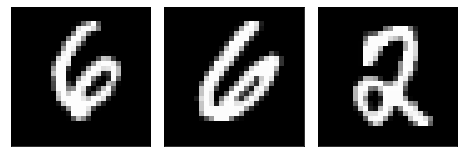

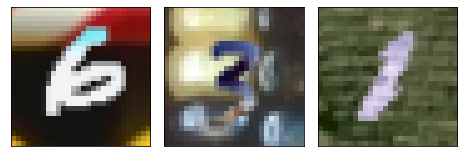

In [13]:
from tut7.data import MNISTMDataset
from tut7.plot_utils import dataset_first_n

image_size = 28
batch_size = 4
tf_source = tvtf.Compose([ tvtf.Resize(image_size), tvtf.ToTensor(), tvtf.Normalize(mean=(0.1307,), std=(0.3081,)) ])
tf_target = tvtf.Compose([
    tvtf.Resize(image_size), tvtf.ToTensor(), tvtf.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

ds_source = tv.datasets.MNIST(root=data_dir, train=True, transform=tf_source, download=True)
# Custom PyTorch Dataset class to load MNIST-M
ds_target = MNISTMDataset(os.path.join(data_dir, 'mnist_m', 'mnist_m_train'),
                          os.path.join(data_dir, 'mnist_m', 'mnist_m_train_labels.txt'),
                         transform=tf_target)

dataset_first_n(ds_source, 3, cmap='gray');
dataset_first_n(ds_target, 3);

In [14]:
# Dataloaders
dl_source = torch.utils.data.DataLoader(ds_source, batch_size)
dl_target = torch.utils.data.DataLoader(ds_target, batch_size)

### Model

Our model will consist of three parts, as in the figure:
- A "deep" CNN for image feature extraction (2x Conv, ReLU, MaxPool)
- A digit-classification head (3x FC, ReLU)
- A domain classification head (2x FC, ReLU), with **gradient reversal layer** (GRL).


<center><img src="img/ganin_da2.png" width="1600" /></center>


What is the gradient reversal layer doing?

GRL is no-op in forward pass, but applies $-\lambda$ factor to gradient in the backward pass.

How can we implement this?

`autograd.Function` objects are what PyTorch uses to record operation history on tensors.

They define the functions used for the forward and backprop of any tensor operator.

In [15]:
from torch.autograd import Function

class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        # Store context for backprop
        ctx.alpha = alpha
        
        # Forward pass is a no-op
        return x

    @staticmethod
    def backward(ctx, grad_output):
        # grad_output is dL/dx (since our forward's output was x)
        
        # Backward pass is just to -alpha the gradient
        # This will become the new dL/dx in the rest of the network
        output =  - ctx.alpha * grad_output

        # Must return number of inputs to forward()
        return output, None

Let's see it in action:

In [16]:
w = torch.tensor([1,2,3,4.], requires_grad=True)
t = 2 * w + 1
t = GradientReversalFn.apply(t, 0.25)
t

tensor([3., 5., 7., 9.], grad_fn=<GradientReversalFnBackward>)

In [17]:
loss = torch.sum(t)
loss.backward(retain_graph=True) # don't discard computation graph during backward, for later vizualization
w.grad

tensor([-0.5000, -0.5000, -0.5000, -0.5000])

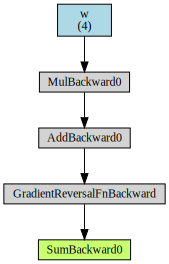

In [18]:
import torchviz
torchviz.make_dot(loss, params=dict(w=w))

Now, let's implement the model exactly as in the paper:

In [19]:
class DACNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, padding=1, stride=1),  # (28+2P-F)/S + 1 = 26
            nn.BatchNorm2d(64), nn.MaxPool2d(2), nn.ReLU(True),    # 26 / 2 = 13
            nn.Conv2d(64, 50, kernel_size=5, padding=1, stride=1), # (12+2P-F)/S + 1 = 10
            nn.BatchNorm2d(50), nn.MaxPool2d(2), nn.ReLU(True),    # 10 / 2 = 5
            nn.Dropout2d(), 
        )
        self.num_cnn_features = 50 * 5 * 5
        self.class_classifier = nn.Sequential(
            nn.Linear(self.num_cnn_features, 100),
            nn.BatchNorm1d(100), nn.Dropout2d(), nn.ReLU(True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100), nn.ReLU(True),
            nn.Linear(100, 10),
            nn.LogSoftmax(dim=1),
        )
        self.domain_classifier = nn.Sequential(
            nn.Linear(self.num_cnn_features, 100),
            nn.BatchNorm1d(100), nn.ReLU(True),
            nn.Linear(100, 2),
            nn.LogSoftmax(dim=1),
        )
    def forward(self, x, grl_lambda=1.0):
        # Handle single-channel input by expanding (repeating) the singleton dimention
        x = x.expand(x.data.shape[0], 3, image_size, image_size)
        
        features = self.feature_extractor(x)
        features = features.view(-1, self.num_cnn_features)
        features_grl = GradientReversalFn.apply(features, grl_lambda)
        class_pred = self.class_classifier(features)        # classify on regular features
        domain_pred = self.domain_classifier(features_grl)  # classify on features after GRL
        return class_pred, domain_pred

Wait, but why let $\lambda$ (`grl_lambda` in the code) change during training (e.g. every epoch)?

- In the beginning of training, the domain loss is extremely noisy since the CNN features are not good yet.
- We don't want to backprop domain confusion into the CNN layers in the beginning.
- Therefore, lambda is gradulaly changed from 0 to 1 in the course of training.
    $$
    \lambda_p = \frac{2}{1+\exp(-10\cdot p)} -1,
    $$
    where $p\in[0,1]$ is the training progress.

In [20]:
model = DACNN()

x0_s, y0_s = next(iter(dl_source))
x0_t, y0_t = next(iter(dl_target))

print('source domain input: ', x0_s.shape, y0_s.shape)
print('target domain input: ', x0_t.shape, y0_t.shape)

# Test forward pass: get class prediction and domain prediction
yhat0_s_c, yhat0_s_d = model(x0_s)
yhat0_t_c, yhat0_t_d = model(x0_t)

print('yhat0_t_c:\n', yhat0_t_c, yhat0_t_c.shape)
print('yhat0_t_d:\n', yhat0_t_d, yhat0_t_d.shape)

source domain input:  torch.Size([4, 1, 28, 28]) torch.Size([4])
target domain input:  torch.Size([4, 3, 28, 28]) torch.Size([4])
yhat0_t_c:
 tensor([[-2.9556, -2.0405, -2.0426, -2.6291, -2.0487, -1.9392, -2.7778, -2.2558,
         -2.3180, -2.5512],
        [-2.0808, -3.1958, -2.2480, -2.7248, -1.9556, -2.5797, -1.5869, -2.5399,
         -2.2374, -2.8892],
        [-1.9534, -2.4835, -1.8684, -2.4796, -2.0358, -3.0086, -2.4753, -2.7293,
         -2.3817, -2.1640],
        [-2.5958, -2.1273, -2.8562, -2.5320, -1.7657, -2.6998, -2.6604, -2.7680,
         -2.1450, -1.7080]], grad_fn=<LogSoftmaxBackward>) torch.Size([4, 10])
yhat0_t_d:
 tensor([[-0.3585, -1.1998],
        [-0.8676, -0.5447],
        [-0.6741, -0.7126],
        [-0.8918, -0.5275]], grad_fn=<LogSoftmaxBackward>) torch.Size([4, 2])


### Training

In [21]:
lr = 1e-3
n_epochs = 1

# Setup optimizer as usual
model = DACNN()
optimizer = optim.Adam(model.parameters(), lr)

# Two loss functions this time (can generally be different)
loss_fn_class = torch.nn.NLLLoss()
loss_fn_domain = torch.nn.NLLLoss()

In [22]:
batch_size = 256
dl_source = torch.utils.data.DataLoader(ds_source, batch_size)
dl_target = torch.utils.data.DataLoader(ds_target, batch_size)

# We'll train the same number of batches from both datasets
max_batches = min(len(dl_source), len(dl_target))

In [23]:
for epoch_idx in range(n_epochs):
    print(f'Epoch {epoch_idx+1:04d} / {n_epochs:04d}', end='\n=================\n')
    dl_source_iter = iter(dl_source)
    dl_target_iter = iter(dl_target)

    for batch_idx in range(max_batches):
        optimizer.zero_grad()
        # Training progress and GRL lambda
        p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
        grl_lambda = 2. / (1. + np.exp(-10 * p)) - 1

        # === Train on source domain
        X_s, y_s = next(dl_source_iter)
        y_s_domain = torch.zeros(batch_size, dtype=torch.long) # generate source domain labels: 0

        class_pred, domain_pred = model(X_s, grl_lambda)
        loss_s_label = loss_fn_class(class_pred, y_s)           # source classification loss
        loss_s_domain = loss_fn_domain(domain_pred, y_s_domain) # source domain loss (via GRL)

        # === Train on target domain
        X_t, _ = next(dl_target_iter) # Note: ignoring target domain class labels!
        y_t_domain = torch.ones(batch_size, dtype=torch.long) # generate target domain labels: 1

        _, domain_pred = model(X_t, grl_lambda)
        loss_t_domain = loss_fn_domain(domain_pred, y_t_domain) # target domain loss (via GRL)
        
        # === Optimize
        loss = loss_t_domain + loss_s_domain + loss_s_label
        loss.backward()
        optimizer.step()
        
        print(f'[{batch_idx+1}/{max_batches}] '
              f'class_loss: {loss_s_label.item():.4f} ' f's_domain_loss: {loss_s_domain.item():.4f} '
              f't_domain_loss: {loss_t_domain.item():.4f} ' f'grl_lambda: {grl_lambda:.3f} '
             )
        if batch_idx == 10:
            print('This is just a demo, stopping...')
            break

Epoch 0001 / 0001
[1/231] class_loss: 2.4172 s_domain_loss: 1.1109 t_domain_loss: 0.4515 grl_lambda: 0.000 
[2/231] class_loss: 2.2705 s_domain_loss: 1.0442 t_domain_loss: 0.4806 grl_lambda: 0.022 
[3/231] class_loss: 2.1664 s_domain_loss: 0.9797 t_domain_loss: 0.4975 grl_lambda: 0.043 
[4/231] class_loss: 2.0120 s_domain_loss: 0.9326 t_domain_loss: 0.5375 grl_lambda: 0.065 
[5/231] class_loss: 1.9922 s_domain_loss: 0.8885 t_domain_loss: 0.5575 grl_lambda: 0.086 
[6/231] class_loss: 1.8970 s_domain_loss: 0.8295 t_domain_loss: 0.5826 grl_lambda: 0.108 
[7/231] class_loss: 1.8194 s_domain_loss: 0.7794 t_domain_loss: 0.6207 grl_lambda: 0.129 
[8/231] class_loss: 1.7999 s_domain_loss: 0.7407 t_domain_loss: 0.6560 grl_lambda: 0.150 
[9/231] class_loss: 1.6827 s_domain_loss: 0.7087 t_domain_loss: 0.6902 grl_lambda: 0.171 
[10/231] class_loss: 1.6249 s_domain_loss: 0.6685 t_domain_loss: 0.7058 grl_lambda: 0.192 
[11/231] class_loss: 1.5978 s_domain_loss: 0.6444 t_domain_loss: 0.7353 grl_lambd

### Embeddings visualization

It's useful to visualize the space of the convolutional features learned by the model.

Recall, our domain confusion loss was supposed to make images from both domains look the same for the classifier.

<center><img src="img/ganin_da3.png" width="1400"/></center>

The figure shows t-SNE visualizations of the CNN’s activations (a) in case when no adaptation was performed and (b) in case when our adaptation procedure was incorporated into training. Blue points correspond to the source domain examples, while red ones correspond to the target domain.

**Image credits**

Some images in this tutorial were taken and/or adapted from:

- Pan & Yang, 2010, A Survey on Transfer Learning
- C. Olah et al. 2017, Feature Visualization
- Y. Ganin et al. 2015, Domain-Adversarial Training of Neural Networks 
- M. Wulfmeier et al., https://arxiv.org/abs/1703.01461v2
- Sebastian Ruder, http://ruder.io/